# DUC Datathon 2020
## Predicting Total Vertical Depth (TVD)

In this section of the competition we are tasked with building regression machine learning (or other)
model that will be able to predict TVD (True Vertical Depth)

In [82]:
# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import prediction libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Data Import

In [120]:
# import well header data
well_header = pd.read_csv("../data/WellHeader_Datathon.csv")
# get submission ids for testing
submission_sample = pd.read_csv("../data/Submission_Sample.csv")

Selection of features to use, here are the feature types:

* **Labels** : EPAssetsId
* **Numeric**: TVD, total depth, KB elevation
* **Geographic**: Surface latitude and longitude
* **Categorical**: Well Profile, Field, formation

Note that the `field` feature will only be used for checking the latitude/longitude clustering.

### Data Cleaning

The data contains `NAN` values of `TVD` that do not need to be predicted. In the next step we filter out these values and only leave the wells that are on the `submission_sample` dataset or that contain real values of `TVD` that we can use to do the training on. 

In [121]:
# get ids for submission
EPAssetId_submission = submission_sample['EPAssetsId']

# filter well header to only include training points (non-NAN TVD) and submission ifs
well_header = well_header[
      (well_header['EPAssetsId'].isin(EPAssetId_submission)) | (pd.notna(well_header.TVD))]

well_header = well_header[[
                        'EPAssetsId',
                        'TVD','TotalDepth','Formation',
                        'Surf_Longitude','Surf_Latitude',
                        'BH_Longitude','BH_Latitude',
                        'WellProfile','Field','KBElevation'
                        ]]

well_header.describe()

EPAssetsId          TVD   TotalDepth  Surf_Longitude  Surf_Latitude  \
count  8.694000e+03  6731.000000  8694.000000     8694.000000    8694.000000   
mean   1.923655e+06  1419.494328  3015.369511     -112.543043      52.664693   
std    7.190129e+05   913.827019  1689.829053        4.094834       1.429560   
min    1.145472e+06   134.000000   888.000000     -119.972137      49.961725   
25%    1.165976e+06   711.455000  1545.000000     -116.902413      51.567844   
50%    2.585176e+06   765.890000  2254.500000     -110.502463      51.922961   
75%    2.605988e+06  2206.350000  4463.000000     -108.934929      54.214698   
max    2.625908e+06  4366.000000  7848.000000     -107.746019      56.594819   

       BH_Longitude  BH_Latitude  KBElevation  
count   8694.000000  8694.000000  8694.000000  
mean    -112.542676    52.665151   784.799708  
std        4.094726     1.430171   133.153498  
min     -119.999593    49.964650   569.800000  
25%     -116.903199    51.567990   696.100000  
50%     -110.489656    51.923925   720.800000  
75%     -108.931956    54.222186   862.000000  
max     -107.726882    56.580394  1377.000000

### Data Exploration

First, we can look a few cross-plots of certain variables of interest.

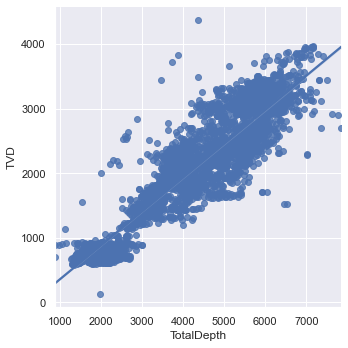

In [85]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", 
            data=well_header, fit_reg=True, height= 5, legend=True);

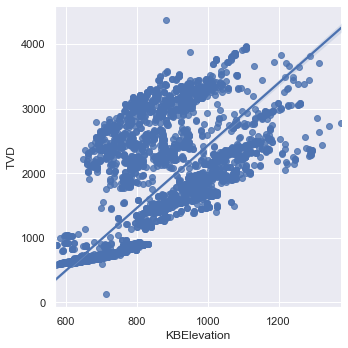

In [86]:
sns.set()
sns.lmplot( x="KBElevation", y="TVD", 
            # hue = 'WellProfile',
            data=well_header, fit_reg=True, height= 5, legend=True);

We can see from the two plots above that both `KVElevation` and `TotalDepth` are strongly correlated to `TVD`

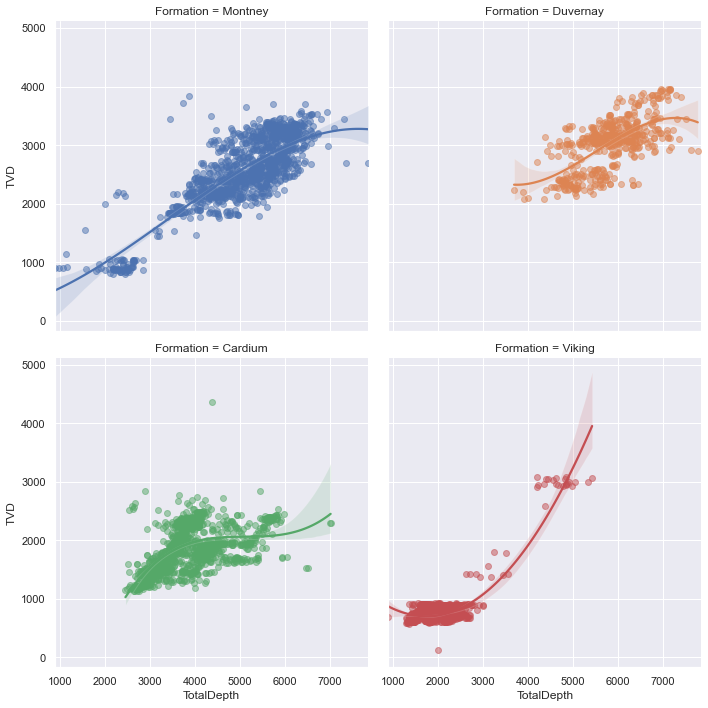

In [87]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=True,hue='Formation',legend=False,col="Formation",col_wrap=2, height=5,order=3,
            scatter_kws={'alpha':0.5});

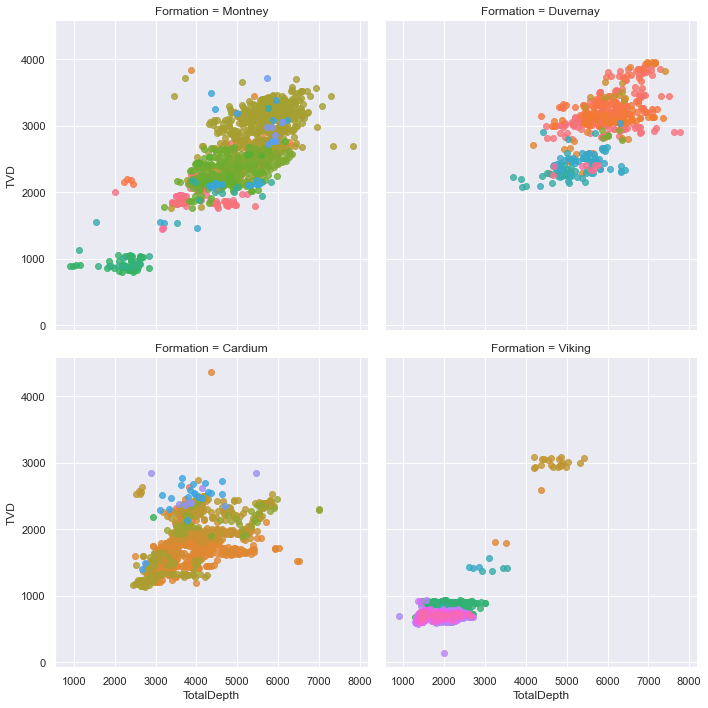

In [88]:
sns.set()
sns.lmplot( x="TotalDepth", y="TVD", data=well_header, 
            fit_reg=False,hue='Field',legend=False,col="Formation",col_wrap=2, height=5);

The two plots above show that both `Formation` and `Field` are important contributors to the prediction of TVD.

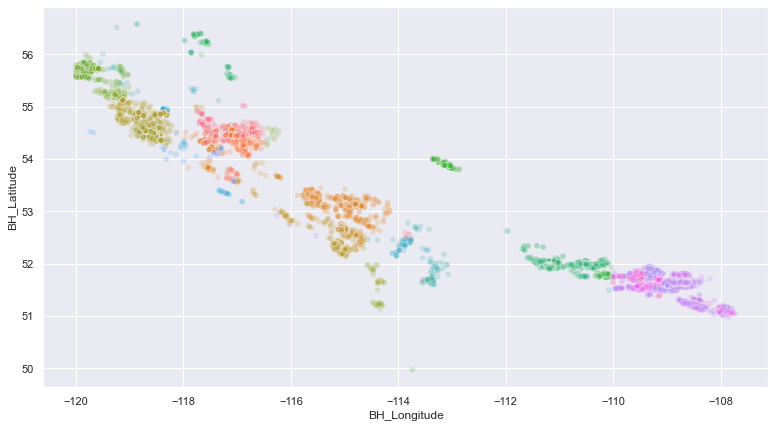

In [122]:
# label field column (for cluster metrics comparisons)
well_header['Field'] = well_header['Field'].astype('category')
well_header['Field_code'] = well_header['Field'].cat.codes

# quick plot
sns.set()
plt.figure(figsize = (13,7))
sns.scatterplot(well_header['BH_Longitude'], 
                well_header['BH_Latitude'],alpha=0.2,
                hue=well_header['Field'],legend=False
                )

We can see above that the data is clustered in certain geographical oil and gas fields. Below we use a clustering method called Density-based spatial clustering of applications with noise (DBSCAN).

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. In our case, this is benefitial.

For further information :

* https://en.wikipedia.org/wiki/DBSCAN
* https://scikit-learn.org/stable/modules/clustering.html#dbscan  

In our case, we use the `Field` feature as a metric on how the clusterin performs. However, the `Field` feature is not used in the final modelling.

In [128]:
# Compute DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# cluster lat long coordinates
lat_longs = well_header[[
    'Surf_Longitude','Surf_Latitude',
    # 'BH_Longitude','BH_Latitude'
    ]]
db = DBSCAN(eps=0.1, min_samples=1).fit(lat_longs)

# get sample
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels_true = np.array(well_header.Field_code)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print out metrics
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lat_longs, labels))

Estimated number of clusters: 91
Estimated number of noise points: 0
Homogeneity: 0.587
Completeness: 0.906
V-measure: 0.713
Adjusted Rand Index: 0.283
Adjusted Mutual Information: 0.698
Silhouette Coefficient: 0.172


Below we run the clustering again but this time with a predicted output of cluster labels (using sci-kit learn function `fit_predict`)

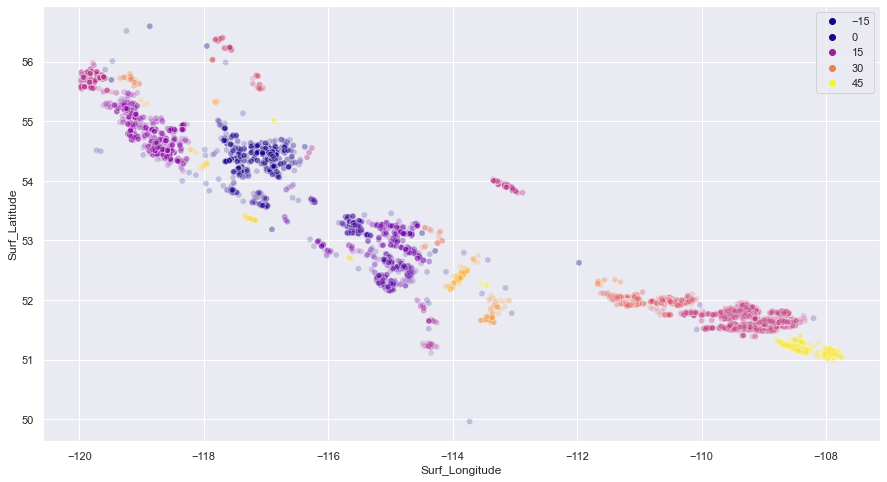

In [129]:
# re-run with prediction values
db = DBSCAN(eps=0.1, min_samples = 3)
clusters = db.fit_predict(lat_longs)

# quick plot with clusters
plt.figure(figsize = (15,8))
sns.scatterplot(well_header['Surf_Longitude'], 
                well_header['Surf_Latitude'],
                alpha=0.2,hue=clusters,palette="plasma")

# add clusters back to df
well_header['DBSCAN_Clusters']=clusters


Select colummns of interest

In [130]:
well_header_clean = well_header[[
                              'EPAssetsId',
                              'TVD','TotalDepth', 'KBElevation',
                              'Formation', 'WellProfile','DBSCAN_Clusters',
                              ]]

well_header_clean.sample(10)                              

EPAssetsId      TVD  TotalDepth  KBElevation Formation  WellProfile  \
5378      1166132   692.07      1426.0        668.2    Viking   Horizontal   
3140      2586206  2539.95      5013.0        685.6   Montney   Horizontal   
1725      2598013      NaN      2333.0        711.3    Viking   Horizontal   
6844      1167060      NaN      2298.0        704.9    Viking   Horizontal   
7049      1151269   610.70      1408.0        619.1    Viking   Horizontal   
5502      1163023   702.75      1570.0        705.0    Viking   Horizontal   
6320      1151078   646.60      1540.0        639.2    Viking   Horizontal   
3767      2595461  3360.64      6217.0        997.5  Duvernay  Directional   
609       2608348  2007.57      3546.0       1078.8   Cardium   Horizontal   
10206     2615540      NaN      5431.0        937.5  Duvernay  Directional   

       DBSCAN_Clusters  
5378                42  
3140                12  
1725                20  
6844                20  
7049                20  
5502                20  
6320                20  
3767                 0  
609                  6  
10206               28

### Predicting TVD using the Random Forests alorithm

In [131]:
# extract data to use in the validation stage
well_header_validation = well_header_clean[pd.isna(well_header_clean.TVD)]

# get unique values of formation, clusters, and well profile 
# from validation set to filter the training set
validation_clusters = well_header_validation.DBSCAN_Clusters.unique()
validation_formation = well_header_validation.Formation.unique()
validation_profile = well_header_validation.WellProfile.unique()

# filter training set
well_header_train = well_header_clean[pd.notna(well_header_clean.TVD)][
        well_header_clean.DBSCAN_Clusters.isin(validation_clusters)][
        well_header_clean.Formation.isin(validation_formation)][
        well_header_clean.WellProfile.isin(validation_profile)]

Above we filter the data further so that the traning set contains the same unique features as the validation set, thereby obtaining a model that will match the validation set.

Below we split the training set into a test and training set to fit the model. We'll use the model on the validation set for prediction.

In [132]:
features = [
            'TotalDepth',
            'Formation',
            'WellProfile',
            'KBElevation',
            'DBSCAN_Clusters']

target = ['TVD']
X = well_header_train[features]
y = well_header_train[target]

# hot encode categorical variables
X = pd.get_dummies(X, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters"], 
                    prefix=["fm", "profile","dbscan_cluster"])

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

# fit regressor
regr = RandomForestRegressor()
regr.fit(X, y)

# get prediction
y_prediction = regr.predict(X_test)

# get RMSE
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print("The test RMSE is :",RMSE)


The test RMSE is : 23.798073844562506


### Predict and write TVD to file for submission

In [133]:
X_validation = well_header_validation[features]

# hot encode
X_validation = pd.get_dummies(X_validation, 
                    columns=[
                            "Formation", 
                            "WellProfile",
                            "DBSCAN_Clusters"], 
                    prefix=["fm", "profile","dbscan_cluster"])

# get prediction
y_validation = regr.predict(X_validation)

well_header_submission = well_header_validation['EPAssetsId'].to_frame()

well_header_submission['Predicted_TVD'] = y_validation

well_header_submission.to_csv("../predictions/predicted_tvd.csv")